# Time Series Analysis: Forecasting Regional Electrical Demand

### Steps

* Loading the Data
* Basic EDA
* Exploring Drift and Seasonality
* Modeling Seasonal Background Load
* Load forecasting

In [1]:
import datetime as dt
import numpy as np
import pandas as pd

import scipy.fft

from sklearn import base
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
#!wget https://raw.githubusercontent.com/truggles/EIA_Cleaned_Hourly_Electricity_Demand_Data/master/data/release_2020_Oct/regions/NE.csv

--2023-10-31 10:23:41--  https://raw.githubusercontent.com/truggles/EIA_Cleaned_Hourly_Electricity_Demand_Data/master/data/release_2020_Oct/regions/NE.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1487836 (1.4M) [text/plain]
Saving to: ‘NE.csv’

NE.csv              100%[===================>]   1.42M  --.-KB/s    in 0.06s   

2023-10-31 10:23:42 (22.1 MB/s) - ‘NE.csv’ saved [1487836/1487836]



In [4]:
df_NE = pd.read_csv('NE.csv')
df_NE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43848 entries, 0 to 43847
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_time            43848 non-null  object 
 1   raw demand (MW)      43848 non-null  float64
 2   cleaned demand (MW)  43848 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.0+ MB


In [5]:
df_NE.columns = df_NE.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df_NE['date_time'] = pd.to_datetime(df_NE['date_time'])
df_NE.head()

,date_time,raw_demand_MW,cleaned_demand_MW
0,2015-07-02 00:00:00,17653.0,17653
1,2015-07-02 01:00:00,17286.0,17286
2,2015-07-02 02:00:00,16701.0,16701
3,2015-07-02 03:00:00,15220.0,15220
4,2015-07-02 04:00:00,13594.0,13594


In [6]:
df_NE.describe()

,date_time,raw_demand_MW,cleaned_demand_MW
count,43848,43848.000000,43848.000000
mean,2017-12-31 11:30:00,13874.842501,13875.772099
min,2015-07-02 00:00:00,0.000000,8494.000000
25%,2016-09-30 17:45:00,12011.000000,12011.000000
50%,2017-12-31 11:30:00,13588.000000,13588.500000
75%,2019-04-02 05:15:00,15310.000000,15310.000000
max,2020-07-01 23:00:00,25763.000000,25763.000000
std,NaN,2598.584172,2596.024883


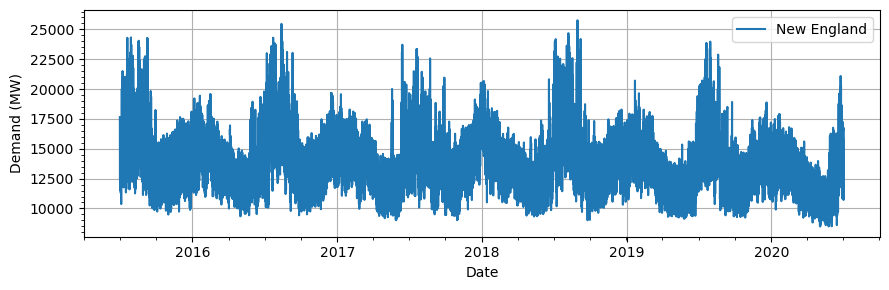

In [7]:
plt.figure(figsize=(9,3))
plt.plot(df_NE['date_time'], df_NE['cleaned_demand_MW'], label='New England')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.minorticks_on()
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

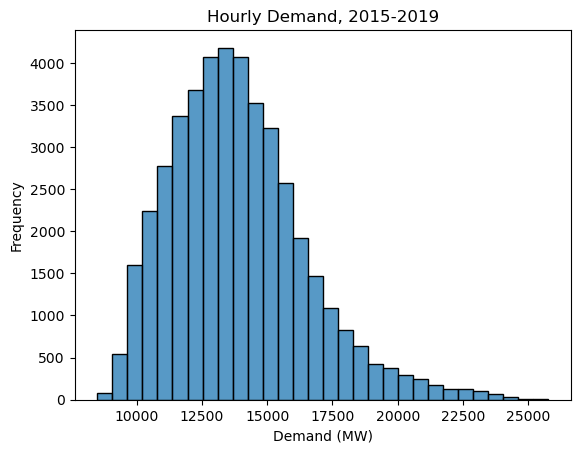

In [8]:
sns.histplot(data=df_NE, x='cleaned_demand_MW', bins=30)
plt.xlabel('Demand (MW)')
plt.ylabel('Frequency')
plt.title('Hourly Demand, 2015-2019')
plt.show()

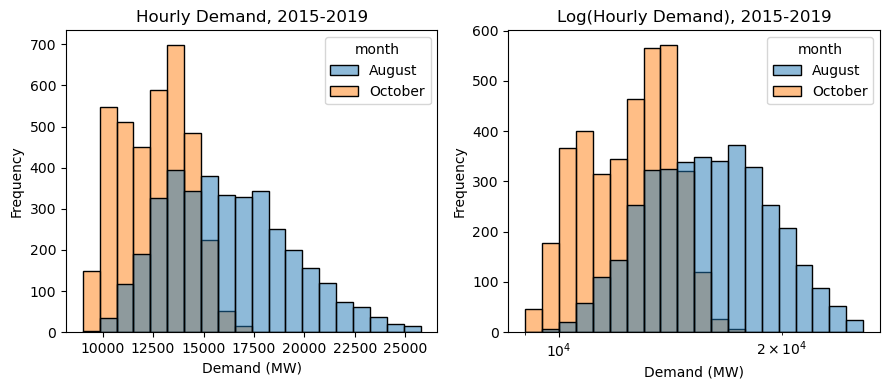

In [9]:
df_NE['month'] = df_NE['date_time'].dt.strftime('%B')

plotmonths = [8, 10]
df_seasonal = df_NE[df_NE['date_time'].dt.month.isin(plotmonths)]

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

sns.histplot(data=df_seasonal, x='cleaned_demand_MW', bins=20, hue='month', ax=axes[0])
axes[0].set_xlabel('Demand (MW)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Hourly Demand, 2015-2019')

sns.histplot(data=df_seasonal, x='cleaned_demand_MW', bins=20, hue='month', log_scale=True, ax=axes[1])
axes[1].set_xlabel('Demand (MW)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log(Hourly Demand), 2015-2019')

plt.tight_layout()
plt.show()

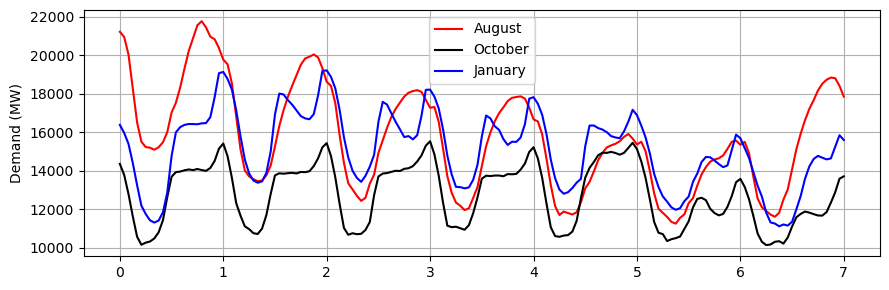

In [10]:
start_date1 = pd.to_datetime('2015-08-04 00:00:00')
end_date1 = pd.to_datetime('2015-08-11 00:00:00')

start_date2 = pd.to_datetime('2015-10-05 00:00:00')
end_date2 = pd.to_datetime('2015-10-12 00:00:00')

start_date3 = pd.to_datetime('2016-01-04 00:00:00')
end_date3 = pd.to_datetime('2016-01-11 00:00:00')

subset1 = df_NE.loc[(df_NE['date_time'] >= start_date1) & (df_NE['date_time'] <= end_date1)].copy()
subset2 = df_NE.loc[(df_NE['date_time'] >= start_date2) & (df_NE['date_time'] <= end_date2)].copy()
subset3 = df_NE.loc[(df_NE['date_time'] >= start_date3) & (df_NE['date_time'] <= end_date3)].copy()


plt.figure(figsize=(9,3))
plt.plot((subset1['date_time']-start_date1)/dt.timedelta(days=1), subset1['cleaned_demand_MW'], label='August', color='red')
plt.plot((subset2['date_time']-start_date2)/dt.timedelta(days=1), subset2['cleaned_demand_MW'], label='October', color='black')
plt.plot((subset3['date_time']-start_date3)/dt.timedelta(days=1), subset3['cleaned_demand_MW'], label='January', color='blue')
plt.ylabel('Demand (MW)')


plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

## Cross-validation for time series

In [11]:
columns = ['date_time', 'cleaned_demand_MW']

train_start = pd.to_datetime('2015-07-02 00:00:00')
train_end = pd.to_datetime('2018-07-01 23:00:00')

val_start = pd.to_datetime('2018-07-02 00:00:00')
val_end = pd.to_datetime('2019-07-01 23:00:00')

test_start = pd.to_datetime('2019-07-02 00:00:00')
test_end = pd.to_datetime('2020-07-01 23:00:00')

df_train = df_NE.loc[(df_NE['date_time'] >= train_start) & (df_NE['date_time'] <= train_end)].copy()[columns]
df_val = df_NE.loc[(df_NE['date_time'] >= val_start) & (df_NE['date_time'] <= val_end)].copy()[columns]
df_test = df_NE.loc[(df_NE['date_time'] >= test_start) & (df_NE['date_time'] <= test_end)].copy()[columns]

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26304 entries, 0 to 26303
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date_time          26304 non-null  datetime64[ns]
 1   cleaned_demand_MW  26304 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 616.5 KB


## Mean Model

A good baseline is the mean model, which has a MSE equal to the variance of the data. We'll take the square root to look at RMSE. Another metric we can consider is the 𝑅2 score. This will be very bad for the mean model. 

In [13]:
np.sqrt(df_val.cleaned_demand_MW.var())

2684.356183757364

In [14]:
metrics.r2_score(df_val.cleaned_demand_MW, [df_val.cleaned_demand_MW.mean()]*len(df_val.cleaned_demand_MW))

0.0

## Fourier Components Model

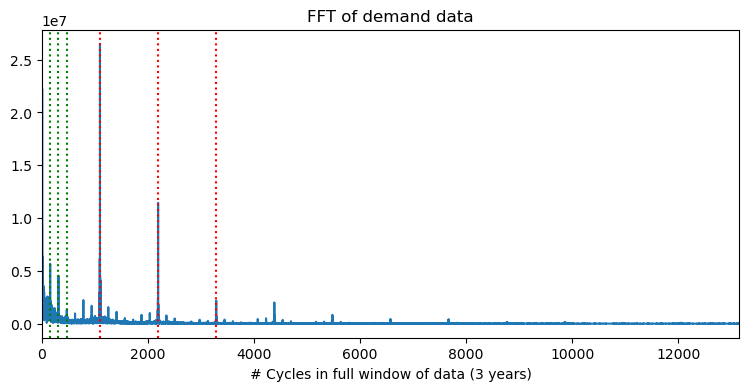

In [15]:
fft = scipy.fft.fft((df_train.cleaned_demand_MW - df_train.cleaned_demand_MW.mean()).values)

daily_cycles_in_3_years = 3*365
daily_harmonic2 = daily_cycles_in_3_years*2
daily_harmonic3 = daily_cycles_in_3_years*3

weekly_cycles_in_3_years = 3*365/7
weekly_harmonic2 = weekly_cycles_in_3_years*2
weekly_harmonic3 = weekly_cycles_in_3_years*3

plt.figure(figsize=(9,4))
plt.plot(np.abs(fft))
plt.xlim([0, len(np.abs(fft))/2])
plt.title("FFT of demand data")
plt.xlabel('# Cycles in full window of data (3 years)')
plt.axvline(daily_cycles_in_3_years, color='r', ls=':')
plt.axvline(daily_harmonic2, color='r', ls=':')
plt.axvline(daily_harmonic3, color='r', ls=':')
plt.axvline(weekly_cycles_in_3_years, color='g', ls=':')
plt.axvline(weekly_harmonic2, color='g', ls=':')
plt.axvline(weekly_harmonic3, color='g', ls=':');

In [16]:
print(f'Daily cycles and harmonics: {daily_cycles_in_3_years}, {daily_harmonic2}, {daily_harmonic3}')
print(f'weekly cycles and harmonics: {weekly_cycles_in_3_years}, {weekly_harmonic2}, {weekly_harmonic3}')

Daily cycles and harmonics: 1095, 2190, 3285
weekly cycles and harmonics: 156.42857142857142, 312.85714285714283, 469.2857142857142


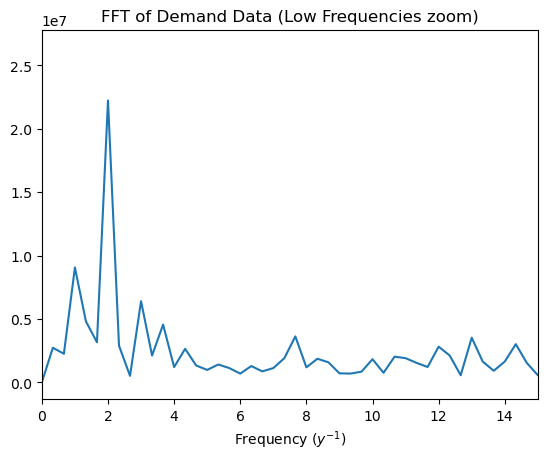

In [17]:
plt.plot(1./3 * np.arange(len(fft)), np.abs(fft))
plt.title("FFT of Demand Data (Low Frequencies zoom)")
plt.xlim([0,15])
plt.xlabel('Frequency ($y^{-1}$)');

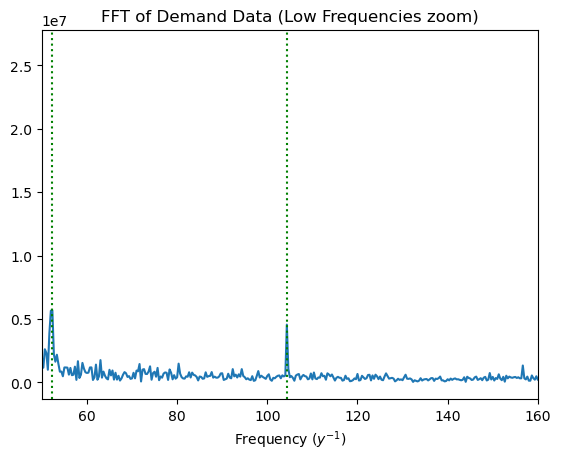

In [18]:
plt.plot(1./3 * np.arange(len(fft)), np.abs(fft))
plt.title("FFT of Demand Data (Low Frequencies zoom)")
plt.xlim([50,160])
plt.axvline(weekly_cycles_in_3_years/3, color='g', ls=':')
plt.axvline(weekly_harmonic2/3, color='g', ls=':')
plt.xlabel('Frequency ($y^{-1}$)');

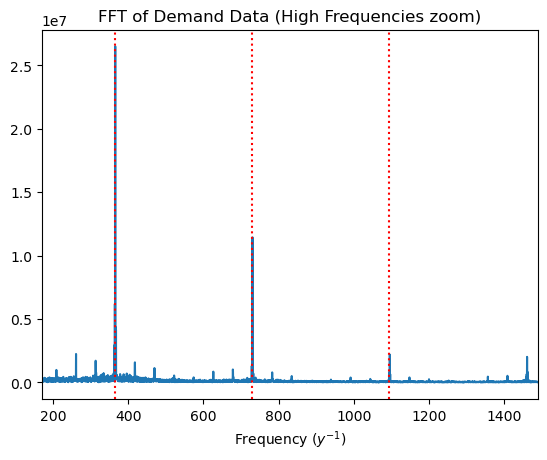

In [19]:
plt.plot(1./3 * np.arange(len(fft)), np.abs(fft))
plt.title("FFT of Demand Data (High Frequencies zoom)")
#plt.ylim([0,400000])
plt.xlim([170, (365*4) + 30])
plt.xlabel('Frequency ($y^{-1}$)')
plt.axvline(daily_cycles_in_3_years/3, color='r', ls=':')
plt.axvline(daily_harmonic2/3, color='r', ls=':')
plt.axvline(daily_harmonic3/3, color='r', ls=':');

In [20]:
class FourierComp_Hourly(base.BaseEstimator, base.TransformerMixin):
    #accepts period IN HOURS since the input df we're using here is hourly
    def __init__(self, period):
        self.period = period
    
    def fit(self, X, y=None):
        self.X0 = X[0]
        return self
    
    def transform(self, X):
        dt = (X - self.X0).dt.days * 24 * 2 * np.pi / self.period
        return np.c_[np.sin(dt), np.cos(dt)]

In [21]:
def fourier_factory():
    union = FeatureUnion([('fourier-d', FourierComp_Hourly(24)),
                          ('fourier-dh2', FourierComp_Hourly(24//2)),
                          ('fourier-dh3', FourierComp_Hourly(24//3)),
                          ('fourier-y', FourierComp_Hourly(int(24*365.2524))),
                          ('fourier-yh2', FourierComp_Hourly(24*365.2524//2)),
                          ('fourier-yh3', FourierComp_Hourly(24*365.2524//3))])
    
    pipe = Pipeline([('union', union),
                     ('lr', LinearRegression())])
    
    return pipe

In [22]:
X_train = df_train['date_time']
y_train = df_train['cleaned_demand_MW']


fourier_model = fourier_factory()
fourier_model.fit(X_train, y_train)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('fourier-d',
                                                 FourierComp_Hourly(period=24)),
                                                ('fourier-dh2',
                                                 FourierComp_Hourly(period=12)),
                                                ('fourier-dh3',
                                                 FourierComp_Hourly(period=8)),
                                                ('fourier-y',
                                                 FourierComp_Hourly(period=8766)),
                                                ('fourier-yh2',
                                                 FourierComp_Hourly(period=4383.0)),
                                                ('fourier-yh3',
                                                 FourierComp_Hourly(period=2922.0))])),
                ('lr', LinearRegression())])

In [23]:
y_train_pred = fourier_model.predict(X_train)

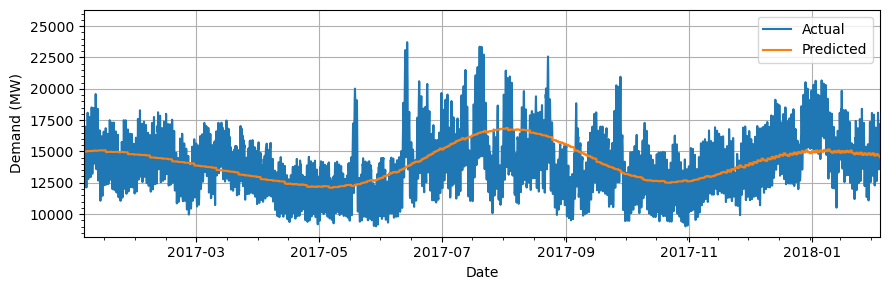

In [24]:
plt.figure(figsize=(9,3))
plt.plot(df_train['date_time'], df_train['cleaned_demand_MW'], label='Actual')
plt.plot(df_train['date_time'], y_train_pred, label='Predicted')
plt.xlim([pd.to_datetime('2017-01-04 00:00:00'), pd.to_datetime('2018-02-04 00:00:00')])
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.minorticks_on()
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()